In [393]:
import pandas as pd
import numpy as np
import datetime

### Data 

In [394]:
from influxdb import DataFrameClient

config = {'host': "xxxxxxxxxxxx",
          'port': 8086,
          'username': "xxxxxxxxxxxx",
          'password': "xxxxxxxxxxxx",
          'database': "xxxxxxxxxxxx"}     

domino_client = DataFrameClient(host=config['host'],
                                port=config['port'],
                                username=config['username'],
                                password=config['password'],
                                database=config['database'])

config = {'host': "xxxxxxxxxxxx",
          'port': 8086,
          'username': "xxxxxxxxxxxx",
          'password': "xxxxxxxxxxxx",
          'database': "xxxxxxxxxxxx"}

gc_client = DataFrameClient(host=config['host'],
                            port=config['port'],
                            username=config['username'],
                            password=config['password'],
                            database=config['database'])

config = {'host': "xxxxxxxxxxxx",
          'port': 8086,
          'username': "xxxxxxxxxxxx",
          'password': "xxxxxxxxxxxx",
          'database': "xxxxxxxxxxxx"}

np_client = DataFrameClient(host=config['host'],
                            port=config['port'],
                            username=config['username'],
                            password=config['password'],
                            database=config['database'])


In [395]:
def read_db(client, select_clause, field, return_local_time=False, offset=None, scale=1.) -> pd.DataFrame:
    """
        Fetches data from influx database
        Args:
            query_type: str
        Returns:
            >>> dataframe[field]: pd.DataFrame
    """
#     start_time, end_time = get_start_end_time(query_type, offset=offset)

#     log.info(f'Fetching {field} with {list(tags.values())} tags data for period from {start_time} to {end_time} (UTC time)')
#     # start_time = convert_to_strf(convert_to_utc(start_time))
#     # end_time = convert_to_strf(convert_to_utc(end_time))
#     start_time = convert_to_strf(start_time)
#     end_time = convert_to_strf(end_time)

#     select_clause = self.make_query(field_name=field,
#                                     measurement_name=measurement,
#                                     tags=tags,
#                                     start_time=start_time,
#                                     end_time=end_time,
#                                     freq=freq,
#                                     agg=agg,
#                                     scale=scale)
    res = client.query(select_clause)

    df_list, df_cols = [], []
    for key, column in res.items():
        df_list.append(res[key])
        df_cols.append(key[1][0][0])

    if df_list:
        # List is not empty
        data = pd.concat(df_list, axis=1).astype(float) #.fillna(method='bfill')
        data.columns = [field]
    else:
        data = pd.DataFrame(columns=[field])
        return data

    if return_local_time==True:
        # convert utc time to local time
        data.index = data.index.tz_convert('Europe/Helsinki').tz_localize(None)
    else:
        data.index = data.index.tz_localize(None)
    print(f"Retrieved data: {data}")
    return data

def make_query(field_name="price", measurement_name="nordicpower",
               tags={"Type":'FCR-N'}, start_time='now()', end_time="now()",
               freq='1h', agg='max', scale=1, fill='linear') -> str:
    """
        A wrapper function to generate string clauses for InfluxDBClient
    """
    # make condition string on tags
    tag = ""
    tag_name = ''
    for k, v in tags.items():
        tag += "\"{}\"=\'{}\' AND ".format(k, v)
        tag_name += ', \"{}\"'.format(k)
    # make full request string
    select_clause = ('SELECT {}(\"{}\")*{} FROM \"{}\" ' \
                     "WHERE {} time >= \'{}\' AND time < \'{}\' " \
                     'GROUP BY time({}){} fill({})'
                     ).format(agg, field_name, scale, measurement_name, tag,
                              start_time, end_time, freq, tag_name, fill)
    print(f'Requesting query: {select_clause}')
    return select_clause


### AIMS: 

    1 - check which forecast is better 
    2 - automate metric analysis
    

#### 1 - check which forecast is better 

####     2 - automate metric analysis

### Fetch the data 

In [441]:
from dateutil.relativedelta import relativedelta
start_time='2021-03-29 22:00:00'
end_time="2021-04-05 22:00:00"
#slr_start_time = (pd.Timestamp(start_time)-relativedelta(years=1, months=-6)).strftime('%Y-%m-%d %H:%M:%S')
slr_start_time = start_time
#slr_end_time = (pd.Timestamp(end_time)-relativedelta(years=1, months=-6)).strftime('%Y-%m-%d %H:%M:%S')
slr_end_time = end_time
print(slr_start_time, slr_end_time)
clause = make_query(field_name='down_energy',
                    measurement_name="dominoes",
                    tags={"Type":'FCR-N'}, 
                    start_time=start_time, 
                    end_time=end_time,
                    freq='15m', 
                    agg='max', 
                    scale=1,
                    fill='linear')

down_energy = read_db(domino_client, clause, field='down_energy')

clause = make_query(field_name='up_energy',
                    measurement_name="dominoes",
                    tags={"Type":'FCR-N'}, 
                    start_time=start_time, 
                    end_time=end_time,
                    freq='15m', 
                    agg='max', 
                    scale=1,
                    fill='linear')

up_energy = read_db(domino_client, clause, field='up_energy')

clause = make_query(field_name='total',
                    measurement_name="active_power",
                    tags={"dirty":'False', 
                          "name":'Flatroof opt. (E-W)',
                          "energy_source":'solar'}, 
                    start_time=slr_start_time,
                    end_time=slr_end_time,
                    freq='15m', 
                    agg='mean', 
                    scale=-0.001,
                    fill='linear')

solar_energy = read_db(gc_client, clause, field='total')

clause = make_query(field_name='price',
                    measurement_name="nordicpower",
                    tags={"Type":'FCR-N'}, 
                    start_time=start_time, 
                    end_time=end_time,
                    freq='15m', 
                    agg='max', 
                    scale=1,
                    fill='previous')

price = read_db(domino_client, clause, field='price').fillna(method='bfill')


clause = make_query(field_name='amr_kw',
                    measurement_name="nordicpower",
                    tags={"Type":'LVDC'}, 
                    start_time=(pd.Timestamp(start_time)-relativedelta(years=3)).strftime('%Y-%m-%d %H:%M:%S'), 
                    end_time=(pd.Timestamp(end_time)-relativedelta(years=3)).strftime('%Y-%m-%d %H:%M:%S'),
                    freq='15m', 
                    agg='max', 
                    scale=1,
                    fill='linear')

lvdc_load = read_db(domino_client, clause, field='amr_kw')


clause = make_query(field_name='q50',
                    measurement_name="dominoes",
                    tags={"Type":'FCR-N price'}, 
                    start_time=start_time, 
                    end_time=end_time,
                    freq='15m', 
                    agg='max', 
                    scale=1,
                    fill='linear')

price_frcst = read_db(domino_client, clause, field='q50').fillna(method='bfill')

clause = make_query(field_name='q50',
                    measurement_name="dominoes",
                    tags={"Type":'FCR-N down_energy'}, 
                    start_time=start_time, 
                    end_time=end_time,
                    freq='15m', 
                    agg='max', 
                    scale=1,
                    fill='linear')

down_energy_frcst = read_db(domino_client, clause, field='q50')

clause = make_query(field_name='q50',
                    measurement_name="dominoes",
                    tags={"Type":'FCR-N up_energy'}, 
                    start_time=start_time, 
                    end_time=end_time,
                    freq='15m', 
                    agg='max', 
                    scale=1,
                    fill='linear')

up_energy_frcst = read_db(domino_client, clause, field='q50')

clause = make_query(field_name='state',
                    measurement_name="dominoes",
                    tags={"Type":'bess test'}, 
                    start_time=start_time, 
                    end_time=end_time,
                    freq='15m', 
                    agg='max', 
                    scale=1,
                    fill='linear')

state = read_db(domino_client, clause, field='state')

clause = make_query(field_name='power_activated',
                    measurement_name="dominoes",
                    tags={"Type":'bess test',
                         'resource':'LVDC_BESS'}, 
                    start_time=start_time, 
                    end_time=end_time,
                    freq='10s', 
                    agg='max', #mean
                    scale=1,
                    fill='linear')

lvdc_bess_power_true = read_db(domino_client, clause, field='power_activated')

clause = make_query(field_name='power_activated',
                    measurement_name="dominoes",
                    tags={"Type":'bess test',
                         'resource':'LUT_BESS'}, 
                    start_time=start_time, 
                    end_time=end_time,
                    freq='10s', 
                    agg='max', #mean
                    scale=1,
                    fill='linear')

gc_bess_power_true = read_db(domino_client, clause, field='power_activated')

clause = make_query(field_name='power_required',
                    measurement_name="dominoes",
                    tags={"Type":'bess test',
                         'resource':'LUT_BESS'}, 
                    start_time=start_time, 
                    end_time=end_time,
                    freq='10s', 
                    agg='mean',
                    scale=1,
                    fill='linear')

gc_bess_power_frcst = read_db(domino_client, clause, field='power_required')


clause = make_query(field_name='power_required',
                    measurement_name="dominoes",
                    tags={"Type":'bess test',
                         'resource':'LVDC_BESS'}, 
                    start_time=start_time, 
                    end_time=end_time,
                    freq='10s', 
                    agg='mean',
                    scale=1,
                    fill='linear')

lvdc_bess_power_frcst = read_db(domino_client, clause, field='power_required')



clause = make_query(field_name='power_schedule',
                    measurement_name="dominoes",
                    tags={"Type":'bess test',
                         'resource':'LUT_BESS'}, 
                    start_time=start_time, 
                    end_time=end_time,
                    freq='15m', 
                    agg='max', #mean
                    scale=1000,
                    fill='linear')

gc_bess_power_sched = read_db(domino_client, clause, field='power_schedule')


clause = make_query(field_name='power_schedule',
                    measurement_name="dominoes",
                    tags={"Type":'bess test',
                         'resource':'LVDC_BESS'}, 
                    start_time=start_time, 
                    end_time=end_time,
                    freq='15m', 
                    agg='max', #mean
                    scale=1000,
                    fill='linear')

lvdc_bess_power_sched = read_db(domino_client, clause, field='power_schedule')


clause = make_query(field_name='FCRN_capacity',
                    measurement_name="dominoes",
                    tags={"Type":'accepted'}, 
                    start_time=start_time, 
                    end_time=end_time,
                    freq='15m', 
                    agg='sum', #mean
                    scale=1000,
                    fill='linear')

fcr_capacity = read_db(domino_client, clause, field='FCRN_capacity')


clause = make_query(field_name='FCRN_capacity',
                    measurement_name="dominoes",
                    tags={"Type":'submitted',
                          "resource":"LUT_BESS"}, 
                    start_time=start_time, 
                    end_time=end_time,
                    freq='15m', 
                    agg='max', #mean
                    scale=1000,
                    fill='linear')

gc_fcr_capacity = read_db(domino_client, clause, field='FCRN_capacity')

clause = make_query(field_name='FCRN_capacity',
                    measurement_name="dominoes",
                    tags={"Type":'submitted',
                          "resource":"LVDC_BESS"}, 
                    start_time=start_time, 
                    end_time=end_time,
                    freq='15m', 
                    agg='max', #mean
                    scale=1000,
                    fill='linear')

lvdc_fcr_capacity = read_db(domino_client, clause, field='FCRN_capacity')


clause = make_query(field_name='price',
                    measurement_name="nordpool",
                    tags={"area":'FI'}, 
                    start_time=start_time, 
                    end_time=end_time,
                    freq='15m', 
                    agg='max', #mean
                    scale=1,
                    fill='previous')

spot_price = read_db(np_client, clause, field='price')



clause = make_query(field_name='q50',
                    measurement_name="dominoes",
                    tags={"Type":'wholesale price'}, 
                    start_time=start_time, 
                    end_time=end_time,
                    freq='15m', 
                    agg='max', 
                    scale=1,
                    fill='previous')

spot_price_frcst = read_db(domino_client, clause, field='q50')


2021-03-29 22:00:00 2021-04-05 22:00:00
Requesting query: SELECT max("down_energy")*1 FROM "dominoes" WHERE "Type"='FCR-N' AND  time >= '2021-03-29 22:00:00' AND time < '2021-04-05 22:00:00' GROUP BY time(15m), "Type" fill(linear)
Retrieved data:                      down_energy
2021-03-29 22:00:00     0.000000
2021-03-29 22:15:00     0.000000
2021-03-29 22:30:00     0.000000
2021-03-29 22:45:00     0.000000
2021-03-29 23:00:00     0.000000
...                          ...
2021-04-05 20:45:00     0.000000
2021-04-05 21:00:00     0.000094
2021-04-05 21:15:00     0.000000
2021-04-05 21:30:00     0.000059
2021-04-05 21:45:00     0.000804

[672 rows x 1 columns]
Requesting query: SELECT max("up_energy")*1 FROM "dominoes" WHERE "Type"='FCR-N' AND  time >= '2021-03-29 22:00:00' AND time < '2021-04-05 22:00:00' GROUP BY time(15m), "Type" fill(linear)
Retrieved data:                      up_energy
2021-03-29 22:00:00  -0.210083
2021-03-29 22:15:00  -0.086454
2021-03-29 22:30:00  -0.023129
2021

Retrieved data:                      FCRN_capacity
2021-03-29 22:00:00           35.0
2021-03-29 22:15:00           35.0
2021-03-29 22:30:00           35.0
2021-03-29 22:45:00           35.0
2021-03-29 23:00:00            0.0
...                            ...
2021-04-05 20:45:00           35.0
2021-04-05 21:00:00            0.0
2021-04-05 21:15:00           35.0
2021-04-05 21:30:00           35.0
2021-04-05 21:45:00           15.0

[672 rows x 1 columns]
Requesting query: SELECT max("FCRN_capacity")*1000 FROM "dominoes" WHERE "Type"='submitted' AND "resource"='LUT_BESS' AND  time >= '2021-03-29 22:00:00' AND time < '2021-04-05 22:00:00' GROUP BY time(15m), "Type", "resource" fill(linear)
Retrieved data:                      FCRN_capacity
2021-03-29 22:00:00           20.0
2021-03-29 22:15:00           20.0
2021-03-29 22:30:00           20.0
2021-03-29 22:45:00           20.0
2021-03-29 23:00:00            0.0
...                            ...
2021-04-05 20:45:00           20.0
2021-0

In [442]:
solar_energy[solar_energy<0.0]=0
lvdc_solar_energy = solar_energy*(10/70)
gc_solar_energy = solar_energy

### KPIs

In [443]:
bess_cost = 0.0817 # euro/kWh
lvdc_max_power = 15
gc_max_power = 20
# FCFC = np.sum(fcr_capacity[fcr_capacity>0](bess_cost*(down_energy_frcst.abs()+up_energy_frcst.abs())+elec_cost*down_energy_frcst))

In [444]:
acc = fcr_capacity
acc.loc[acc[acc["FCRN_capacity"]>0.0].index,"FCRN_capacity"] = 1.0

gc_fcr_capacity_binary = (gc_fcr_capacity * acc.values)/gc_max_power
lvdc_fcr_capacity_binary = (lvdc_fcr_capacity * acc.values)/lvdc_max_power

In [445]:
elec_purch_frcst_gc = spot_price_frcst*1e-3 + 0.0528 + 0.0279372 + 0.0024 # euro/kWh
elec_purch_gc = spot_price*1e-3 + 0.0528 + 0.0279372 + 0.0024 # euro/kWh

elec_purch_frcst_lvdc = spot_price_frcst*1e-3 + 0.0528 + 0.0279372 + 0.0024 # euro/kWh
elec_purch_lvdc = spot_price*1e-3 + 0.0438 + 0.0279372 + 0.0024 # euro/kWh

elec_sale_frcst = spot_price_frcst*1e-3 - 0.0007 # euro/kWh
elec_sale = spot_price*1e-3 - 0.0007 # euro/kWh

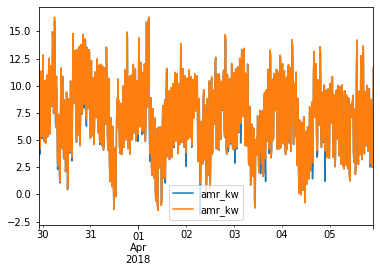

In [446]:
(pd.concat([lvdc_load - (solar_energy*(7.5/70)).values + ((up_energy*15)*lvdc_fcr_capacity_binary.values).values,
            lvdc_load - (solar_energy*(7.5/70)).values], axis=1)).plot()

In [447]:
gc_params = {'el_purch_frcst':elec_purch_frcst_gc,
             'el_purch':elec_purch_gc,
             'max_power':gc_max_power,
             'fcrn_capacity':gc_fcr_capacity_binary,
             'bess_power':gc_bess_power_frcst,
             'solar_energy':gc_solar_energy}

lvdc_params = {'el_purch_frcst':elec_purch_frcst_lvdc,
               'el_purch':elec_purch_lvdc,
               'max_power':lvdc_max_power,
               'fcrn_capacity':lvdc_fcr_capacity_binary,
               'bess_power':lvdc_bess_power_frcst,
               'solar_energy':lvdc_solar_energy}
test_site = {'lvdc': lvdc_params,
             'gc':gc_params}

Assessing lvdc demo site

FCFC 9.58452634089493 euro

FCMA 13.95196085934722 euro

FBFC 14.681594692706753 euro

FBMA 17.00314034631441 euro

KPI 5.1: 0.7955936626433254 

FER: -37.32370639999999 kWh

RER: -20.955249951966174 kWh

KPI 5.2: 0.5614461149004799

FBMA: 17.00314034631441 euros

FCMA: 13.95196085934722 euros

KPI 5.3: 1.2186918038064183



/home/aleksei/miniconda3/envs/fcrn_bidding/lib/python3.7/site-packages/ipykernel_launcher.py:113: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Assessing gc demo site

FCFC 12.882712100713942 euro

FCMA 19.387161073422796 euro

FBFC 19.550801816735063 euro

FBMA 23.60054200395557 euro

KPI 5.1: 0.8021405777448511 

FER: -51.945135199999996 kWh

RER: -33.969611494487836 kWh

KPI 5.2: 0.6539517389587589

FBMA: 23.60054200395557 euros

FCMA: 19.387161073422796 euros

KPI 5.3: 1.2173284120648669



/home/aleksei/miniconda3/envs/fcrn_bidding/lib/python3.7/site-packages/ipykernel_launcher.py:113: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


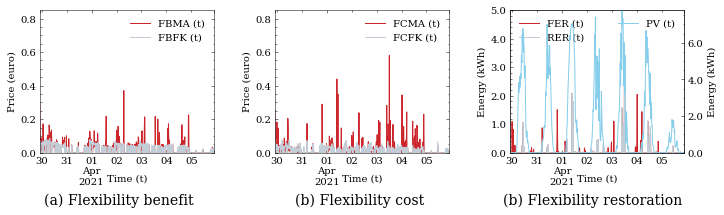

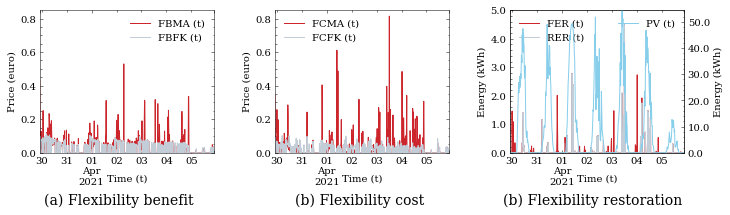

In [450]:
for site, params in test_site.items():
    print('Assessing {} demo site\n'.format(site))
    
    ### KPI 5.1 - Balancing capacity allocation finacially profitable ###
    el_part = (params['el_purch_frcst']*down_energy_frcst.values*params['max_power']).abs()
    bat_part = bess_cost*((params['max_power']*down_energy_frcst).abs()+(params['max_power']*up_energy_frcst).abs().values)
    FCFC = (params['fcrn_capacity']*(el_part + bat_part.values).values).sum()
    print('FCFC {} euro\n'.format(FCFC.values[0]))
    FCFC_plot = (params['fcrn_capacity']*(el_part + bat_part.values).values).rename(columns={'FCRN_capacity':'FCFK (t)'})
    
    el_part = (params['el_purch']*down_energy.values*params['max_power']).abs()
    bat_part = bess_cost*((params['max_power']*down_energy).abs()+(params['max_power']*up_energy).abs().values)
    FCMA = (params['fcrn_capacity']*(el_part + bat_part.values).values).sum()
    print('FCMA {} euro\n'.format(FCMA.values[0]))
    FCMA_plot = (params['fcrn_capacity']*(el_part + bat_part.values).values).rename(columns={'FCRN_capacity':'FCMA (t)'})
    
    el_part = (params['el_purch_frcst']*up_energy_frcst.abs().values*params['max_power']).abs().values
    FBFC = (params['fcrn_capacity']*(price_frcst*params['max_power']*0.001*0.25+el_part).values).sum()
    print('FBFC {} euro\n'.format(FBFC.values[0]))
    FBFC_plot = (params['fcrn_capacity']*(price_frcst*params['max_power']*0.001*0.25+el_part).values).rename(columns={'FCRN_capacity':'FBFK (t)'})
    
    el_part = (params['el_purch']*up_energy.abs().values*params['max_power']).abs().values
    FBMA = (params['fcrn_capacity']*(price*params['max_power']*0.001*0.25+el_part).values).sum()
    print('FBMA {} euro\n'.format(FBMA.values[0]))
    FBMA_plot = (params['fcrn_capacity']*(price*params['max_power']*0.001*0.25+el_part).values).rename(columns={'FCRN_capacity':'FBMA (t)'})
    
    KPI_5_1 = (FBMA/FCMA)/(FBFC/FCFC)
    print(f"KPI 5.1: {KPI_5_1.values[0]} \n")
    
    kpi_5_3_plot = pd.concat([FBMA_plot,FBFC_plot], axis=1)
    kpi_5_3_plot2 = pd.concat([FCMA_plot,FCFC_plot],axis=1)
        
    ### KPI 5.2  - Potential adoption of distributed generation increased ###
    
    bess_power_true = ((params['bess_power']*0.96).resample('15T').mean()*0.25)  
    bess_power_true[bess_power_true>=0] = 0
    # possible charge from solar energy 
    df = (-params['solar_energy']/bess_power_true.resample('15T').mean().values).replace([np.inf, -np.inf], np.nan).fillna(0)
    df[df>=1] = 1.0
    df[df<=0] = 0.0
    FER = (params['fcrn_capacity']*bess_power_true.values).sum() 
    RER = (params['fcrn_capacity']*(bess_power_true*df.values).values).sum() 
    KPI_5_2 = (RER)/(FER)
    print(f"FER: {FER.values[0]} kWh\n")
    print(f"RER: {RER.values[0]} kWh\n")
    print(f"KPI 5.2: {KPI_5_2.values[0]}\n")
    
    FER_plot = (params['fcrn_capacity']*bess_power_true.values).rename(columns={'FCRN_capacity':'FER (t)'})
    RER_plot = (params['fcrn_capacity']*(bess_power_true*df.values).values).rename(columns={'FCRN_capacity':'RER (t)'})
    kpi_5_2_plot = -1*pd.concat([FER_plot, RER_plot], axis=1)

    ### KPI 5.3 - All participants are compensated fairly ###
    KPI_5_3 = (FBMA)/(FCMA)
    print(f"FBMA: {FBMA.values[0]} euros\n")
    print(f"FCMA: {FCMA.values[0]} euros\n")
    print(f"KPI 5.3: {KPI_5_3.values[0]}\n")
    
    
    ####### Visualize ######## 
    
    import matplotlib.pyplot as plt
    from matplotlib.colors import LogNorm, SymLogNorm
    from matplotlib.ticker import FormatStrFormatter
    import matplotlib.dates as mdates
    from mpl_toolkits.axes_grid1.inset_locator import mark_inset

    with plt.style.context(['/home/aleksei/Downloads/DeepForecastPaper/SciencePlots/styles/science.mplstyle'
                       ]):
        fig, axes = plt.subplots(1, 3, sharey=False, sharex=False)#, figsize=(3.5, 2.625))
        fig.subplots_adjust(wspace=0.35, hspace=0.)#, bottom=0.25)
        fig.set_size_inches(3.5*3.3, 2.625)

        kpi_5_3_plot.plot(ax=axes[0])
        kpi_5_3_plot2.plot(ax=axes[1])
        #(price/price.max()).plot(ax=axes[0])
        axes[1].set_ylabel('Price (euro)')
        axes[1].set_xlabel('Time (t)')
        axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        axes[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        #axes[0].xaxis.set_minor_formatter(mdates.DateFormatter('%Y-%m-%d'))
        axes[0].set_ylabel('Price (euro)')
        axes[0].set_xlabel('Time (t)')
        axes[0].xaxis.set_label_coords(0.5, -0.15)
        axes[1].xaxis.set_label_coords(0.5, -0.15)
        
        axes[0].set_ylim([0.0,0.85])
        axes[1].set_ylim([0.0,0.85])
        
        
        kpi_5_2_plot.plot(ax=axes[2])
        ax = axes[2].twinx()
        (params['solar_energy']).rename(columns={'total':'PV (t)'}).plot(ax=ax, color='skyblue')
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        axes[2].set_ylabel('Energy (kWh)')
        ax.set_ylabel('Energy (kWh)')
        axes[2].set_xlabel('Time (t)')
        axes[2].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        axes[2].xaxis.set_label_coords(0.5, -0.15)
        axes[2].set_ylim([0.0,5.])
        ax.set_ylim([0.0,params['solar_energy'].max().values[0]])
        
        handles, labels = axes[2].get_legend_handles_labels()
        leg = axes[2].legend(handles, labels, loc='upper left')
        handles, labels = ax.get_legend_handles_labels()
        leg = ax.legend(handles, labels, loc='upper right')

        fig.text(0.22, -0.15, '(a) Flexibility benefit', ha="center", size=14)
        fig.text(0.51, -0.15, '(b) Flexibility cost', ha="center", size=14)
        fig.text(0.79, -0.15, '(b) Flexibility restoration', ha="center", size=14)
        #fig.tight_layout()
        fig.savefig(f'./kpi_{site}.eps', format='eps', dpi=1000, bbox_inches='tight')
        fig.savefig(f'./kpi_{site}.pdf', format='pdf', bbox_inches='tight')
        fig.show()

#### Forecasts 

In [451]:
from dateutil.relativedelta import relativedelta
start_time='2021-03-18 22:00:00'
end_time="2021-04-08 22:00:00"
#slr_start_time = (pd.Timestamp(start_time)-relativedelta(years=1, months=-6)).strftime('%Y-%m-%d %H:%M:%S')
slr_start_time = start_time
#slr_end_time = (pd.Timestamp(end_time)-relativedelta(years=1, months=-6)).strftime('%Y-%m-%d %H:%M:%S')
slr_end_time = end_time
clause = make_query(field_name='price',
                    measurement_name="nordicpower",
                    tags={"Type":'FCR-N'}, 
                    start_time=start_time, 
                    end_time=end_time,
                    freq='1h', 
                    agg='max', 
                    scale=1,
                    fill='previous')

price = read_db(domino_client, clause, field='price').fillna(method='bfill')

clause = make_query(field_name='q25',
                    measurement_name="dominoes",
                    tags={"Type":'FCR-N price'}, 
                    start_time=start_time, 
                    end_time=end_time,
                    freq='1h', 
                    agg='max', 
                    scale=1,
                    fill='linear')

price_frcst_25 = read_db(domino_client, clause, field='q25').fillna(method='bfill')

clause = make_query(field_name='q50',
                    measurement_name="dominoes",
                    tags={"Type":'FCR-N price'}, 
                    start_time=start_time, 
                    end_time=end_time,
                    freq='1h', 
                    agg='max', 
                    scale=1,
                    fill='linear')

price_frcst_50 = read_db(domino_client, clause, field='q50').fillna(method='bfill')

clause = make_query(field_name='q75',
                    measurement_name="dominoes",
                    tags={"Type":'FCR-N price'}, 
                    start_time=start_time, 
                    end_time=end_time,
                    freq='1h', 
                    agg='max', 
                    scale=1,
                    fill='linear')

price_frcst_75 = read_db(domino_client, clause, field='q75').fillna(method='bfill')

Requesting query: SELECT max("price")*1 FROM "nordicpower" WHERE "Type"='FCR-N' AND  time >= '2021-03-18 22:00:00' AND time < '2021-04-08 22:00:00' GROUP BY time(1h), "Type" fill(previous)
Retrieved data:                      price
2021-03-18 22:00:00   3.86
2021-03-18 23:00:00   3.03
2021-03-19 00:00:00   3.03
2021-03-19 01:00:00   2.69
2021-03-19 02:00:00   3.03
...                    ...
2021-04-08 17:00:00   8.24
2021-04-08 18:00:00   7.95
2021-04-08 19:00:00   2.20
2021-04-08 20:00:00   2.50
2021-04-08 21:00:00   2.50

[504 rows x 1 columns]
Requesting query: SELECT max("q25")*1 FROM "dominoes" WHERE "Type"='FCR-N price' AND  time >= '2021-03-18 22:00:00' AND time < '2021-04-08 22:00:00' GROUP BY time(1h), "Type" fill(linear)
Retrieved data:                           q25
2021-03-18 22:00:00  3.707274
2021-03-18 23:00:00  3.537959
2021-03-19 00:00:00  3.688775
2021-03-19 01:00:00  3.572017
2021-03-19 02:00:00  3.765639
...                       ...
2021-04-08 17:00:00  4.744617
202

/home/aleksei/miniconda3/envs/fcrn_bidding/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


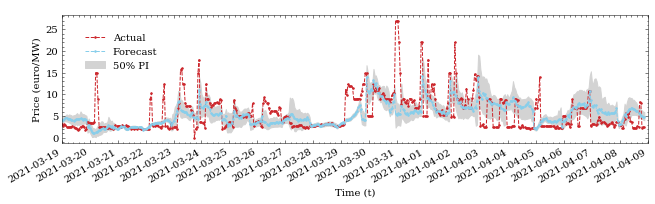

In [512]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
from matplotlib.ticker import FormatStrFormatter
import matplotlib.dates as mdates
#import subprocess

with plt.style.context(['/home/aleksei/Downloads/DeepForecastPaper/SciencePlots/styles/science.mplstyle'
                   ]):
    fig, ax = plt.subplots(1, 1, sharey=False, sharex=False)
    fig.subplots_adjust(wspace=0.35, hspace=0., bottom=0.)
    fig.set_size_inches(3.5*3, 2.625)
    ax.fill_between(price.index, price_frcst_25['q25'], price_frcst_75['q75'], 
                    color='lightgrey', label='50% PI')
    ax.plot(price.index, price.values, '--o', markersize=1.5, label='Actual')
    ax.plot(price_frcst_50.index, price_frcst_50.values, 
            '--o', markersize=1.5, color='skyblue', label='Forecast')
    ax.set_ylabel('Price (euro/MW)')
    ax.set_xlabel('Time (t)')
    fig.legend(loc='upper left',  bbox_to_anchor=(0.1, 0.45, 0.5, 0.5))
    
    from matplotlib.dates import DayLocator, HourLocator, DateFormatter, drange
    ax.xaxis.set_major_locator(DayLocator())
    #ax.xaxis.set_minor_locator(HourLocator(range(0, 25, 6)))
    #ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
    #ax.fmt_xdata = DateFormatter('%Y-%m-%d %H:%M:%S')
    #ax.format_xdata = mdates.DateFormatter('%m-%d')
    fig.autofmt_xdate()
    ax.set_xlim([datetime.date(2021, 3, 19), datetime.date(2021, 4, 9)])
    #fig.savefig(f'./price_forecast.eps', format='eps', dpi=1000, bbox_inches='tight')
    #fig.savefig(f'./price_forecast.pdf', format='pdf', bbox_inches='tight')
    fig.savefig('price_forecast.svg', format='svg', bbox_inches='tight')
    #subprocess.call('inkscape price_forecast.svg -M price_forecast.emf', shell=True)
    fig.show()

In [531]:
from dateutil.relativedelta import relativedelta
start_time='2021-03-18 22:00:00'
end_time="2021-04-07 22:00:00"
#slr_start_time = (pd.Timestamp(start_time)-relativedelta(years=1, months=-6)).strftime('%Y-%m-%d %H:%M:%S')
slr_start_time = start_time
#slr_end_time = (pd.Timestamp(end_time)-relativedelta(years=1, months=-6)).strftime('%Y-%m-%d %H:%M:%S')
slr_end_time = end_time

clause = make_query(field_name='down_energy',
                    measurement_name="dominoes",
                    tags={"Type":'FCR-N'}, 
                    start_time=start_time, 
                    end_time=end_time,
                    freq='1h', 
                    agg='sum', 
                    scale=1,
                    fill='linear')

down_energy = read_db(domino_client, clause, field='down_energy')

clause = make_query(field_name='up_energy',
                    measurement_name="dominoes",
                    tags={"Type":'FCR-N'}, 
                    start_time=start_time, 
                    end_time=end_time,
                    freq='1h', 
                    agg='sum', 
                    scale=1,
                    fill='linear')

up_energy = read_db(domino_client, clause, field='up_energy')

clause = make_query(field_name='q25',
                    measurement_name="dominoes",
                    tags={"Type":'FCR-N down_energy'}, 
                    start_time=start_time, 
                    end_time=end_time,
                    freq='1h', 
                    agg='sum', 
                    scale=1,
                    fill='linear')

down_energy_frcst_25 = read_db(domino_client, clause, field='q25')

clause = make_query(field_name='q25',
                    measurement_name="dominoes",
                    tags={"Type":'FCR-N up_energy'}, 
                    start_time=start_time, 
                    end_time=end_time,
                    freq='1h', 
                    agg='sum', 
                    scale=1,
                    fill='linear')

up_energy_frcst_25 = read_db(domino_client, clause, field='q25')

clause = make_query(field_name='q50',
                    measurement_name="dominoes",
                    tags={"Type":'FCR-N down_energy'}, 
                    start_time=start_time, 
                    end_time=end_time,
                    freq='1h', 
                    agg='sum', 
                    scale=1,
                    fill='linear')

down_energy_frcst_50 = read_db(domino_client, clause, field='q50')

clause = make_query(field_name='q50',
                    measurement_name="dominoes",
                    tags={"Type":'FCR-N up_energy'}, 
                    start_time=start_time, 
                    end_time=end_time,
                    freq='1h', 
                    agg='sum', 
                    scale=1,
                    fill='linear')

up_energy_frcst_50 = read_db(domino_client, clause, field='q50')

clause = make_query(field_name='q75',
                    measurement_name="dominoes",
                    tags={"Type":'FCR-N down_energy'}, 
                    start_time=start_time, 
                    end_time=end_time,
                    freq='1h', 
                    agg='sum', 
                    scale=1,
                    fill='linear')

down_energy_frcst_75 = read_db(domino_client, clause, field='q75')

clause = make_query(field_name='q75',
                    measurement_name="dominoes",
                    tags={"Type":'FCR-N up_energy'}, 
                    start_time=start_time, 
                    end_time=end_time,
                    freq='1h', 
                    agg='sum', 
                    scale=1,
                    fill='linear')

up_energy_frcst_75 = read_db(domino_client, clause, field='q75')

Requesting query: SELECT sum("down_energy")*1 FROM "dominoes" WHERE "Type"='FCR-N' AND  time >= '2021-03-18 22:00:00' AND time < '2021-04-07 22:00:00' GROUP BY time(1h), "Type" fill(linear)
Retrieved data:                      down_energy
2021-03-18 22:00:00     0.000394
2021-03-18 23:00:00     0.053639
2021-03-19 00:00:00     0.000000
2021-03-19 01:00:00     0.000512
2021-03-19 02:00:00     0.000000
...                          ...
2021-04-07 17:00:00     0.005233
2021-04-07 18:00:00     0.002897
2021-04-07 19:00:00     0.000000
2021-04-07 20:00:00     0.131424
2021-04-07 21:00:00     0.056306

[480 rows x 1 columns]
Requesting query: SELECT sum("up_energy")*1 FROM "dominoes" WHERE "Type"='FCR-N' AND  time >= '2021-03-18 22:00:00' AND time < '2021-04-07 22:00:00' GROUP BY time(1h), "Type" fill(linear)
Retrieved data:                      up_energy
2021-03-18 22:00:00  -0.047906
2021-03-18 23:00:00  -0.002986
2021-03-19 00:00:00  -0.011069
2021-03-19 01:00:00  -0.056527
2021-03-19 02:0

/home/aleksei/miniconda3/envs/fcrn_bidding/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


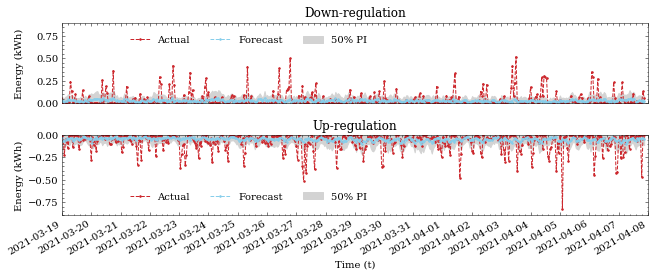

In [555]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
from matplotlib.ticker import FormatStrFormatter
import matplotlib.dates as mdates
#import subprocess

with plt.style.context(['/home/aleksei/Downloads/DeepForecastPaper/SciencePlots/styles/science.mplstyle'
                   ]):
    fig, axes = plt.subplots(2, 1, sharey=False, sharex=True)
    fig.subplots_adjust(wspace=0.35, hspace=0.4, bottom=0.)
    fig.set_size_inches(3.5*3, 1.5*2.625)
    
    axes[0].fill_between(down_energy.index, down_energy_frcst_25['q25'], down_energy_frcst_75['q75'], 
                    color='lightgrey', label='50% PI')
    axes[0].plot(down_energy.index, down_energy.values, '--o', markersize=1.5, label='Actual')
    axes[0].plot(down_energy_frcst_50.index, down_energy_frcst_50.values, 
            '--o', markersize=1.5, color='skyblue', label='Forecast')
    axes[0].set_ylabel('Energy (kWh)')
    axes[0].set_xlabel('Time (t)')
    
    axes[1].fill_between(up_energy.index, up_energy_frcst_25['q25'], up_energy_frcst_75['q75'], 
                    color='lightgrey', label='50% PI')
    axes[1].plot(up_energy.index, up_energy.values, '--o', markersize=1.5, label='Actual')
    axes[1].plot(up_energy_frcst_50.index, up_energy_frcst_50.values, 
            '--o', markersize=1.5, color='skyblue', label='Forecast')
    axes[1].set_ylabel('Energy (kWh)')
    axes[1].set_xlabel('Time (t)')
    
    
    axes[0].legend(loc='upper left',  bbox_to_anchor=(0.1, 0.45, 0.5, 0.5), ncol=3)
    axes[1].legend(loc='upper left',  bbox_to_anchor=(0.1, -0.1, 0.5, 0.5), ncol=3)
    from matplotlib.dates import DayLocator, HourLocator, DateFormatter, drange
    axes[0].xaxis.set_major_locator(DayLocator())
    #ax.xaxis.set_minor_locator(HourLocator(range(0, 25, 6)))
    #ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
    #ax.fmt_xdata = DateFormatter('%Y-%m-%d %H:%M:%S')
    #ax.format_xdata = mdates.DateFormatter('%m-%d')
    fig.autofmt_xdate()
    axes[0].set_ylim([0.0,0.9])
    axes[0].set_title('Down-regulation')
    axes[1].set_title('Up-regulation')
    axes[1].set_ylim([-0.9,0])
    axes[0].set_xlim([datetime.date(2021, 3, 19), datetime.date(2021, 4, 8)])
    fig.align_ylabels(axes)
    #fig.savefig(f'./price_forecast.eps', format='eps', dpi=1000, bbox_inches='tight')
    #fig.savefig(f'./price_forecast.pdf', format='pdf', bbox_inches='tight')
    fig.savefig('energy_forecast.svg', format='svg', bbox_inches='tight')
    #subprocess.call('inkscape price_forecast.svg -M price_forecast.emf', shell=True)
    fig.show()

In [556]:
# import tensorflow.keras.backend as K
import numpy as np

def PI_coverage(target, low_forecast, up_forecast):
    return np.mean((low_forecast <= target)*(target <= up_forecast))


def rho_risk2(y_true, y_pred, rho):
    #
    # This function calculates the quantile risk between the true and the predicted outputs
    #
    num1 = (y_true-y_pred)*rho*(y_true>=y_pred)
    num2 = (y_pred-y_true)*(1-rho)*(y_true<y_pred)
    den  = np.sum(np.abs(y_true), axis=None)
    
    return 2*(np.sum(num1, axis=None)+np.sum(num2, axis=None))/den

def nrmse(y_true, y_pred):
    #
    # The formula is:
    #           K.sqrt(K.mean(K.square(y_pred - y_true)))    
    #    NRMSE = -----------------------------------------------
    #           K.mean(K.sum(y_true))       
    #
    num = K.sqrt(K.mean(K.square(y_true - y_pred), axis=None))
    den = K.mean(K.abs(y_true), axis=None)
    
    return num / den

def rho_risk(y_true, y_pred, rho):
    #
    # This function calculates the quantile risk between the true and the predicted outputs
    #
    num = -np.sum(2*(y_pred-y_true)*(rho*(y_pred<=y_true)-(1-rho)*(y_pred>y_true)), axis=None)
    den  = np.sum(np.abs(y_true), axis=None)
    
    return num/den

def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred))
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return 200 * np.mean(diff)

def ND(y_pred, y_true):
    demoninator = np.sum(np.abs(y_true))
    diff = np.sum(np.abs(y_true - y_pred))
    return 1.0*diff/demoninator

def rmsle(y_pred, y_true) :
    assert len(y_true) == len(y_pred)
    return np.sqrt(np.mean((np.log(1+y_pred) - np.log(1+y_true))**2))

def NRMSE(y_pred, y_true):
    assert len(y_pred) == len(y_true)
    denominator = np.mean(np.abs(y_true))
    diff = np.sqrt(np.mean(((y_pred-y_true)**2)))
    return diff/denominator

def rho_risk22(y_pred,y_true,rho):
    assert len(y_pred) == len(y_true)
    diff1 = (y_true-y_pred)*rho*(y_true>=y_pred)
    diff2 = (y_pred-y_true)*(1-rho)*(y_true<y_pred)
    denominator = np.sum(np.abs(y_true))
    return 2*(np.sum(diff1)+np.sum(diff2))/denominator

In [566]:
PI_coverage(price.values, price_frcst_25.values, price_frcst_75.values)

0.4027777777777778

In [567]:
PI_coverage(up_energy.values, up_energy_frcst_75.values, up_energy_frcst_25.values)

0.7208333333333333

In [568]:
PI_coverage(down_energy.values, down_energy_frcst_25.values, down_energy_frcst_75.values)

0.7979166666666667

In [580]:
PI = []
for i in range(len(price)):
    if (price.iloc[i,0] >= price_frcst_25.iloc[i,0]) & (price.iloc[i,0] <= price_frcst_75.iloc[i,0]):
        PI.append(1)
    else:
        PI.append(0)
np.mean(PI)

0.4027777777777778

In [581]:
ND(price.values, price_frcst_50.values)

0.46922962107824256

In [582]:
ND(up_energy.values, up_energy_frcst_50.values)

1.3396763460744523

In [583]:
ND(down_energy.values, down_energy_frcst_50.values)

1.6624856645985582